### 引入需要的包

In [33]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 1000)
pd.set_option('max_colwidth',100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42 # 给定随机种子的目的是重现相同的计算结果

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

### 数据探索与清洗
#### 读取数据，并查看字段和数据集维度

In [34]:
df_Customer = pd.read_csv('D:\KAOSHI\sf\data/Telco-Customer-Churn.csv') 
df_Customer.name = '电信客户流失数据'

print('Number of Customer Examples = {}'.format(df_Customer.shape[0]))
print('Customer Shape = {}'.format(df_Customer.shape))
print(df_Customer.columns)

Number of Customer Examples = 7043
Customer Shape = (7043, 21)
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [35]:
df_Customer.info()
df_Customer.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No


#### 处理缺失值

In [36]:
df_Customer['TotalCharges'] = df_Customer['TotalCharges'].replace(' ', np.nan).astype(float)

dfs=[df_Customer]
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

电信客户流失数据
customerID column missing values: 0
gender column missing values: 0
SeniorCitizen column missing values: 0
Partner column missing values: 0
Dependents column missing values: 0
tenure column missing values: 0
PhoneService column missing values: 0
MultipleLines column missing values: 0
InternetService column missing values: 0
OnlineSecurity column missing values: 0
OnlineBackup column missing values: 0
DeviceProtection column missing values: 0
TechSupport column missing values: 0
StreamingTV column missing values: 0
StreamingMovies column missing values: 0
Contract column missing values: 0
PaperlessBilling column missing values: 0
PaymentMethod column missing values: 0
MonthlyCharges column missing values: 0
TotalCharges column missing values: 11
Churn column missing values: 0




#### 处理TotalCharges

In [37]:
df_Customer_corr = df_Customer.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_Customer_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_Customer_corr[df_Customer_corr['Feature 1'] == 'TotalCharges']


,Feature 1,Feature 2,Correlation Coefficient
3,TotalCharges,TotalCharges,1.000000
5,TotalCharges,tenure,0.825880
7,TotalCharges,MonthlyCharges,0.651065
13,TotalCharges,SeniorCitizen,0.102411


In [38]:
# 用tenure和MonthlyCharges分组的中位数填充TotalCharges的缺失值
total_charges_median = df_Customer['TotalCharges'].median()
df_Customer['TotalCharges'] = df_Customer['TotalCharges'].fillna(df_Customer.groupby(['tenure', 'MonthlyCharges'])['TotalCharges'].transform('median')).fillna(total_charges_median)

display_missing(df_Customer)

customerID column missing values: 0
gender column missing values: 0
SeniorCitizen column missing values: 0
Partner column missing values: 0
Dependents column missing values: 0
tenure column missing values: 0
PhoneService column missing values: 0
MultipleLines column missing values: 0
InternetService column missing values: 0
OnlineSecurity column missing values: 0
OnlineBackup column missing values: 0
DeviceProtection column missing values: 0
TechSupport column missing values: 0
StreamingTV column missing values: 0
StreamingMovies column missing values: 0
Contract column missing values: 0
PaperlessBilling column missing values: 0
PaymentMethod column missing values: 0
MonthlyCharges column missing values: 0
TotalCharges column missing values: 0
Churn column missing values: 0




#### 2.4Target Distribution

5174名客户留存，占总客户数7043的73.46%。
1869名客户流失，占总客户数7043的26.54%。


<AxesSubplot:xlabel='Churn', ylabel='count'>

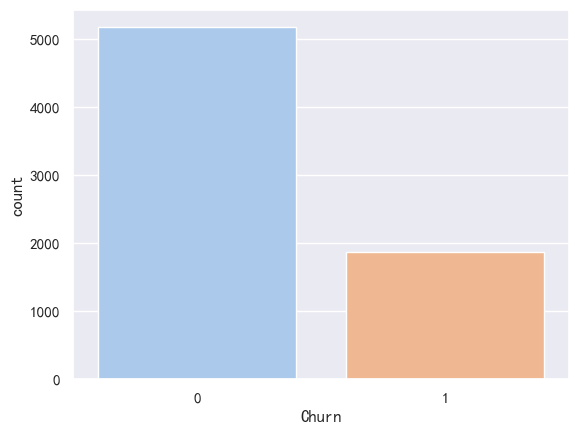

In [39]:
df_Customer['Churn'] = df_Customer['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

churned = df_Customer['Churn'].value_counts()[1]
retained_customers = df_Customer['Churn'].value_counts()[0]
churn_rate = churned / df_Customer.shape[0] * 100
retention_rate = retained_customers / df_Customer.shape[0] * 100
total_customers=df_Customer.shape[0]

print('{}名客户留存，占总客户数{}的{:.2f}%。'.format(retained_customers, total_customers, retention_rate))
print('{}名客户流失，占总客户数{}的{:.2f}%。'.format(total_customers - retained_customers, total_customers, churn_rate))
sns.countplot(data=df_Customer[df_Customer.Churn.notnull()], x="Churn", palette="pastel" )


#### 相关性分析

In [40]:
df_train_corr = df_Customer.drop(['customerID'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True) 
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]


,Feature 1,Feature 2,Correlation Coefficient
6,TotalCharges,tenure,0.825464
8,TotalCharges,MonthlyCharges,0.650864
10,Churn,tenure,0.352229
12,MonthlyCharges,tenure,0.247900
14,MonthlyCharges,SeniorCitizen,0.220173
16,TotalCharges,Churn,0.199037
18,MonthlyCharges,Churn,0.193356
20,SeniorCitizen,Churn,0.150889
22,SeniorCitizen,TotalCharges,0.102652


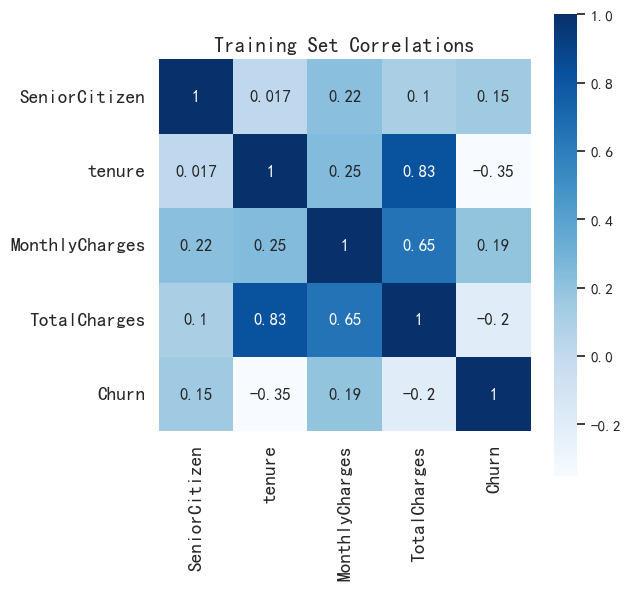

In [41]:
fig, axes = plt.subplots(nrows=1, figsize=(6, 6))
sns.heatmap(df_Customer.drop(['customerID'], axis=1).corr(), ax=axes, annot=True, square=True,cmap='Blues',)
axes.tick_params(axis='x', labelsize=14)
axes.tick_params(axis='y', labelsize=14)
axes.set_title('Training Set Correlations', size=15)
plt.show()

#### 目标分布
##### 连续性特征分析

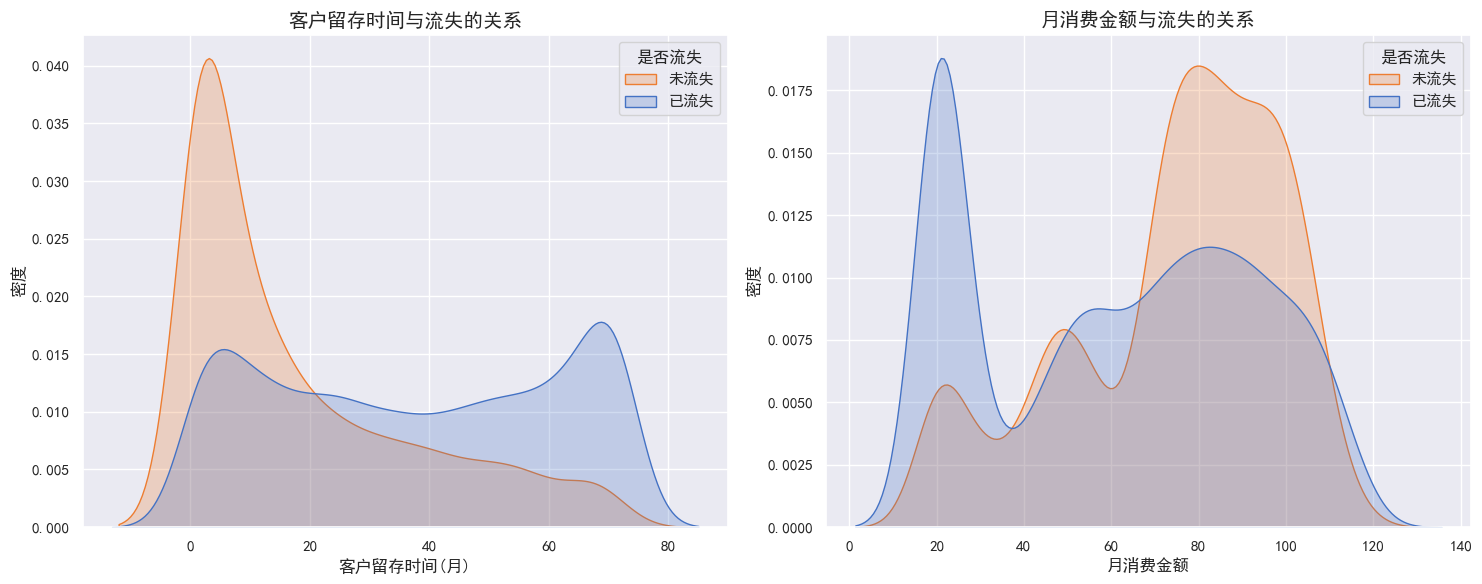

In [42]:

cont_features = ['tenure', 'MonthlyCharges']
retained = df_Customer['Churn'] == 1

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

sns.kdeplot(data=df_Customer, x='tenure', hue='Churn', fill=True, common_norm=False, palette=['#4472C4', '#ED7D31'], ax=axes[0])
axes[0].set_title('客户留存时间与流失的关系', fontsize=14)
axes[0].set_xlabel('客户留存时间(月)', fontsize=12)
axes[0].set_ylabel('密度', fontsize=12)
axes[0].legend(title='是否流失', labels=['未流失', '已流失'])

sns.kdeplot(data=df_Customer, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False, palette=['#4472C4', '#ED7D31'], ax=axes[1])
axes[1].set_title('月消费金额与流失的关系', fontsize=14)
axes[1].set_xlabel('月消费金额', fontsize=12)
axes[1].set_ylabel('密度', fontsize=12)
axes[1].legend(title='是否流失', labels=['未流失', '已流失'])

plt.tight_layout()
plt.show()

##### 分类特征分析

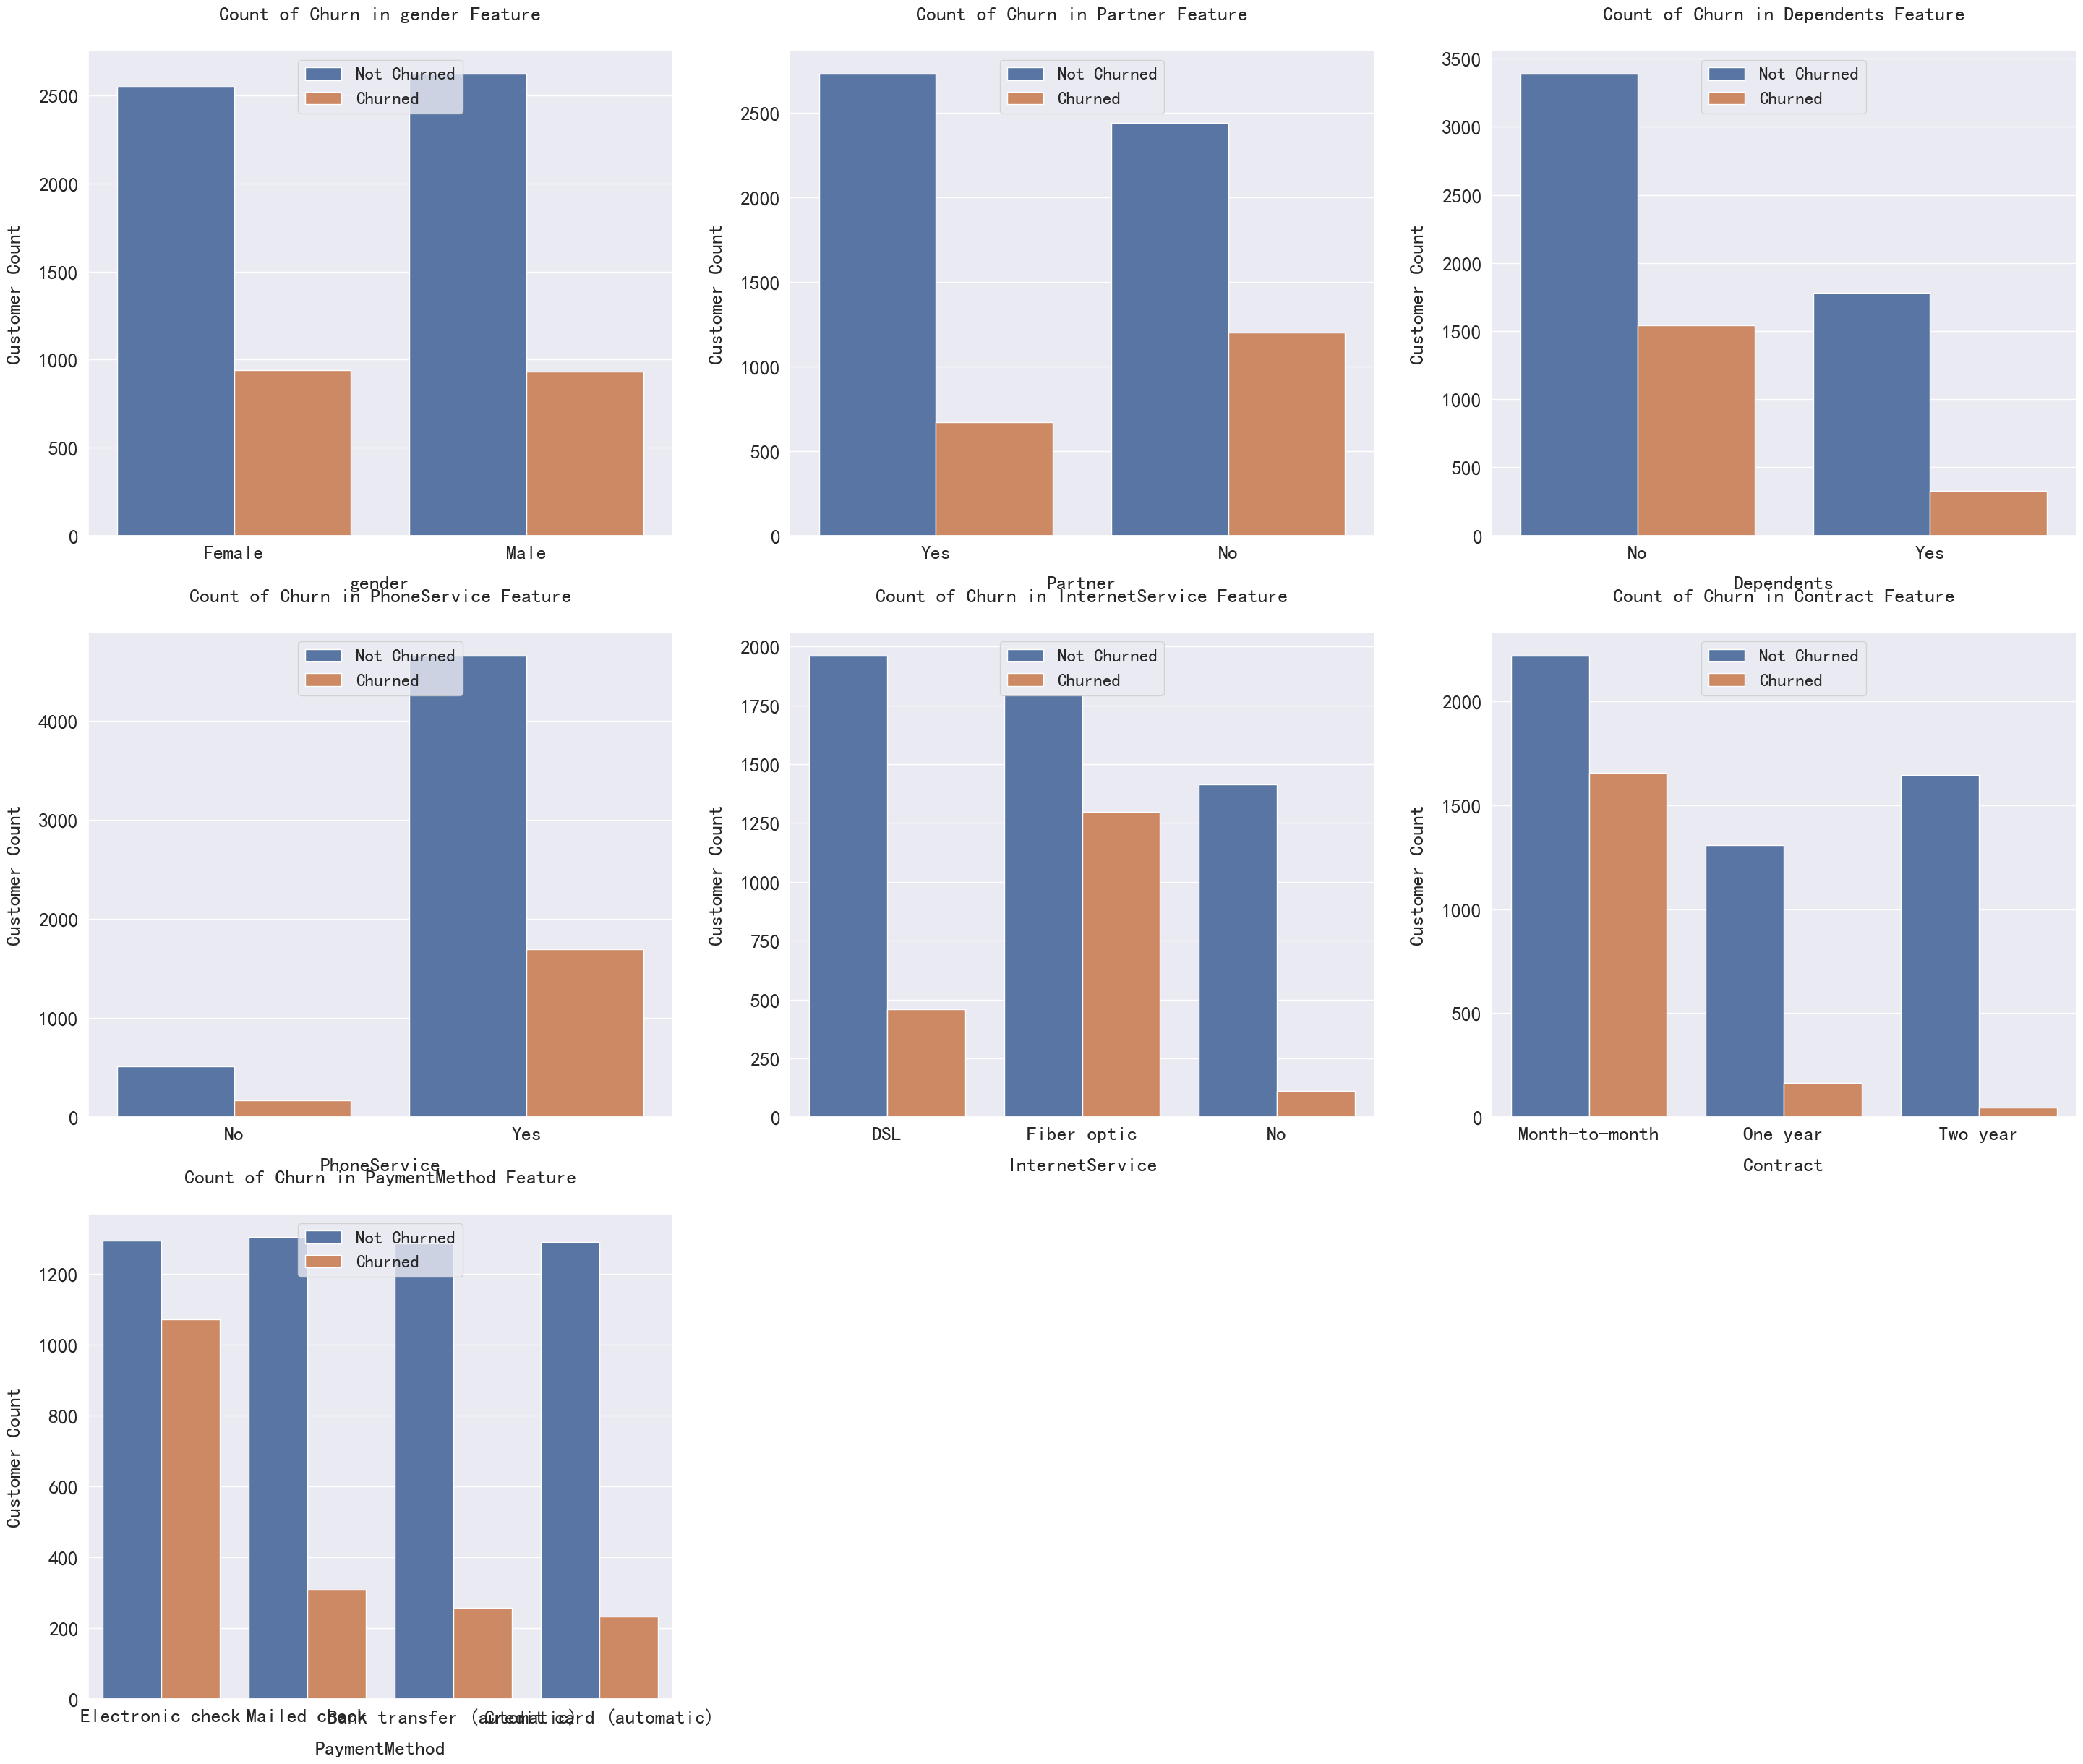

In [43]:
cat_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'Contract', 'PaymentMethod']

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):
    ax = axes[(i - 1) // 3, (i - 1) % 3]
    sns.countplot(x=feature, hue='Churn', data=df, ax=ax)
    
    ax.set_xlabel('{}'.format(feature), size=20, labelpad=15)
    ax.set_ylabel('Customer Count', size=20, labelpad=15)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.legend(['Not Churned', 'Churned'], loc='upper center', prop={'size': 18})
    ax.set_title('Count of Churn in {} Feature'.format(feature), size=20, y=1.05)
plt.show()

In [44]:
df_Customer.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


#### 特征工程

In [45]:
train_df, test_df = train_test_split(df_Customer, test_size=0.3, random_state=SEED)

train_df = train_df.drop('customerID', axis=1)
test_df = test_df.drop('customerID', axis=1)

X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn']
X_test = test_df.drop('Churn', axis=1)
y_test = test_df['Churn']

categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                       'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod']

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

encoded_feature_names = encoder.get_feature_names_out(categorical_features)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_scaled = scaler.transform(X_test[numerical_features])

X_train_processed = np.hstack([X_train_encoded, X_train_scaled])
X_test_processed = np.hstack([X_test_encoded, X_test_scaled])



#### 随机森林

In [46]:
rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_processed, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\n最佳参数: ", best_params)
print("最佳交叉验证ROC-AUC分数: {:.4f}".format(best_score))



Fitting 5 folds for each of 216 candidates, totalling 1080 fits

最佳参数:  {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
最佳交叉验证ROC-AUC分数: 0.8412


In [47]:
rf_params = {
    'n_estimators': 100,
    'max_depth': best_params.get('max_depth', 10),
    'min_samples_split': best_params.get('min_samples_split', 2),
    'min_samples_leaf': best_params.get('min_samples_leaf', 1),
    'max_features': best_params.get('max_features', 'auto'),
    'oob_score': True,
    'random_state': SEED,
    'n_jobs': -1
}

print("\n最终模型参数:")
for key, value in rf_params.items():
    print(f"{key}: {value}")

random_forest = RandomForestClassifier(**rf_params)
random_forest.fit(X_train_processed, y_train)

print("\n训练完成的随机森林模型:")
print(random_forest)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_processed)
y_pred_proba = best_rf.predict_proba(X_test_processed)[:, 1]



最终模型参数:
n_estimators: 100
max_depth: 10
min_samples_split: 10
min_samples_leaf: 4
max_features: log2
oob_score: True
random_state: 42
n_jobs: -1

训练完成的随机森林模型:
RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_jobs=-1, oob_score=True,
                       random_state=42)


                                  Feature  Importance
27                                 tenure    0.184470
29                           TotalCharges    0.152587
28                         MonthlyCharges    0.100078
22                      Contract_Two year    0.077242
7             InternetService_Fiber optic    0.074220
25         PaymentMethod_Electronic check    0.066238
21                      Contract_One year    0.034872
10                     OnlineSecurity_Yes    0.033975
16                        TechSupport_Yes    0.024610
23                   PaperlessBilling_Yes    0.019954
12                       OnlineBackup_Yes    0.016344
9      OnlineSecurity_No internet service    0.015189
13   DeviceProtection_No internet service    0.014995
6                       MultipleLines_Yes    0.014226
8                      InternetService_No    0.014027
2                             Partner_Yes    0.013701
15        TechSupport_No internet service    0.013215
19    StreamingMovies_No int

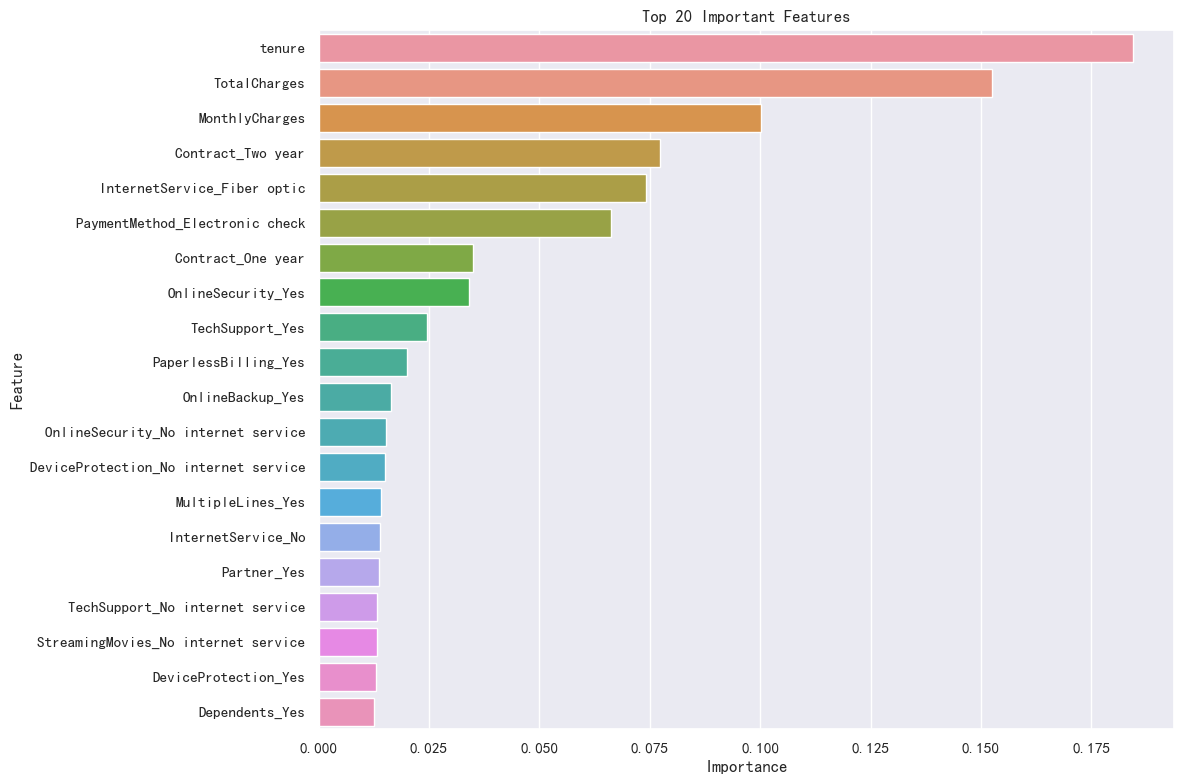

In [48]:
# 特征重要性分析

all_feature_names = list(encoded_feature_names) + numerical_features

feature_importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()
